# **SVD Applications Lab, part 1**

**Instructions:** Work through the cells top-to-bottom. Cells labeled **EXERCISE** include TODOs. Instructor solutions are included as **commented** blocks you can reveal by uncommenting.

**Goals**
- Build geometric intuition for SVD in 2D/3D (unit circle → ellipse, unit sphere → ellipsoid).
- Compute SVD; verify orthogonality; connect $A^\top A$ and $A A^\top$ to right/left singular vectors.
- Use SVD for low-rank approximations; quantify energy and error.
- Compress grayscale & color images with SVD; visualize quality vs. rank.

In [1]:
# Setup: imports & utilities
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(432)

def rotation_2d(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]])

def unit_circle(n=400):
    t = np.linspace(0, 2*np.pi, n)
    return np.vstack([np.cos(t), np.sin(t)])

def plot_axes(ax, length=1.0, color='0.5', lw=0.8):
    ax.plot([0, length], [0,0], color=color, lw=lw)
    ax.plot([0,0], [0, length], color=color, lw=lw)

def arrow(ax, v, **kw):
    ax.arrow(0, 0, v[0], v[1], head_width=0.05*max(1, np.linalg.norm(v)),
             length_includes_head=True, **kw)

def orth_error(Q):
    m, n = Q.shape
    I = np.eye(n)
    return np.linalg.norm(Q.T @ Q - I, 'fro')

## Intro
Recall the SVD of an $n\times d$ matrix $A$:
$$A = U\,\Sigma\,V^\top,$$
where $U$ is $n\times n$ orthogonal, $V$ is $d\times d$ orthogonal, and the nonzero singular values of $A$ appear on the diagonal of the $n\times d$ diagonal matrix $\Sigma$ (ordered $\sigma_1 \ge \sigma_2 \ge \cdots \ge 0$). Right singular vectors (columns of $V$) live in the input space; left singular vectors (columns of $U$) live in the output space.

## 1. Computing SVD and Experimenting

### 1.1 **EXERCISE** — Map the unit circle to a rotated ellipse

In [ ]:
# EXERCISE 1.1 — Define A for a rotated ellipse
import numpy as np

a = 2.5
b = 1.0
theta = np.deg2rad(30)

# TODO: Define A so that the unit circle maps to an ellipse
# with semi-axes lengths a, b, rotated by angle theta.
# hint: first define a rotation matrix R
A = None  # <-- TODO
print("A =\n", A)

In [ ]:
# Plot circle/ellipse with left/right singular vectors labeled
X = unit_circle()
assert A is not None, "Define A above first."
Y = A @ X
U, s, Vt = np.linalg.svd(A)
V = Vt.T
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(X[0], X[1], 'k', lw=1.5)
plot_axes(ax[0], length=1.2)
for i, c in enumerate(['C1','C3']):
    v = V[:, i]
    arrow(ax[0], v, color=c, lw=2)
    ax[0].text(*(1.05*v), f'$v_{i+1}$', color=c)
ax[0].set_aspect('equal'); ax[0].set_title('Input space')
ax[1].plot(Y[0], Y[1], 'k', lw=1.5)
plot_axes(ax[1], length=max(a,b)*1.2)
for i, c in enumerate(['C1','C3']):
    u = U[:, i]
    arrow(ax[1], s[i]*u, color=c, lw=2)
    ax[1].text(*(1.05*s[i]*u), f'$\\sigma_{i+1} u_{i+1}$', color=c)
ax[1].set_aspect('equal'); ax[1].set_title('Output space')
plt.tight_layout(); plt.show()
print("Singular values:", s)
print("Orthogonality errors:", orth_error(V), orth_error(U))

### 1.2 **EXERCISE** — 3D SVD with chosen $\Sigma$, $V$, and $U$ (Plotly, interactive)
Use the sliders to choose singular values $\sigma_1,\sigma_2,\sigma_3$ and the right/left singular vectors via Euler angles.

**Questions:**
- Fix $V=I$ and vary $U$. What rotates?
- Fix $U=I$ and vary $V$. How do input directions rotate?
- Set $\sigma_2 = \sigma_3$. Discuss uniqueness of singular vectors.

In [4]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import FloatSlider, IntSlider, Dropdown, Checkbox, HBox, VBox, Layout, interactive_output
from IPython.display import display
from functools import lru_cache

def rot3d_from_euler(roll, pitch, yaw, seq='ZYX'):
    cr, sr = np.cos(roll),  np.sin(roll)
    cp, sp = np.cos(pitch), np.sin(pitch)
    cy, sy = np.cos(yaw),   np.sin(yaw)
    Rx = np.array([[1, 0, 0],[0, cr, -sr],[0, sr,  cr]])
    Ry = np.array([[cp, 0, sp],[0, 1, 0],[-sp, 0, cp]])
    Rz = np.array([[cy, -sy, 0],[sy,  cy, 0],[0,   0,  1]])
    if seq == 'ZYX':
        return Rz @ Ry @ Rx
    elif seq == 'XYZ':
        return Rx @ Ry @ Rz
    else:
        raise ValueError("Euler seq must be 'ZYX' or 'XYZ'.")

@lru_cache(maxsize=None)
def sphere_samples(n_theta=40, n_phi=20):
    theta = np.linspace(0, 2*np.pi, int(n_theta))
    phi   = np.linspace(0, np.pi,   int(n_phi))
    th, ph = np.meshgrid(theta, phi)
    x = np.cos(th) * np.sin(ph)
    y = np.sin(th) * np.sin(ph)
    z = np.cos(ph)
    return np.stack([x, y, z], axis=0)

def build_A_and_ellipsoid(s1, s2, s3, Vyaw, Vpitch, Vroll, Uyaw, Upitch, Uroll, euler_seq='ZYX', sort_sigmas=True, n_theta=40, n_phi=20):
    sig = np.array([s1, s2, s3], dtype=float)
    if sort_sigmas:
        sig = np.sort(sig)[::-1]
    s1, s2, s3 = sig.tolist()
    Sigma = np.diag([s1, s2, s3])
    to_rad = np.deg2rad
    V = rot3d_from_euler(to_rad(Vroll), to_rad(Vpitch), to_rad(Vyaw), seq=euler_seq)
    U = rot3d_from_euler(to_rad(Uroll), to_rad(Upitch), to_rad(Uyaw), seq=euler_seq)
    A = U @ Sigma @ V.T
    S = sphere_samples(int(n_theta), int(n_phi))
    Y = A @ S.reshape(3, -1)
    Y = Y.reshape(3, *S.shape[1:])
    return (s1, s2, s3), U, A, Y

def axes_traces(U, svals):
    cols = ['#E76F51', '#2A9D8F', '#E9C46A']
    traces = []
    for i, (ui, si, c) in enumerate(zip(U.T, svals, cols), start=1):
        vec = si * ui
        traces.append(go.Scatter3d(x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
                                   mode='lines+text', line=dict(color=c, width=6),
                                   text=[None, f'σ{i} u{i}'], textposition='top center',
                                   textfont=dict(size=11, color=c), showlegend=False))
    return traces

params0 = dict(s1=2.0, s2=1.2, s3=0.6, Vyaw=30.0, Vpitch=10.0, Vroll=-20.0,
               Uyaw=-15.0, Upitch=25.0, Uroll=10.0, euler_seq='ZYX', sort_sigmas=True,
               n_theta=40, n_phi=20)
(s1, s2, s3), U0, A0, Y0 = build_A_and_ellipsoid(**params0)
surf = go.Surface(x=Y0[0], y=Y0[1], z=Y0[2], colorscale='Blues', showscale=False, opacity=0.85)
fig = go.FigureWidget(data=[surf], layout=go.Layout(
    title=r"$A = U\,\Sigma\,V^\top$ (Plotly WebGL)",
    scene=dict(aspectmode='cube',
               xaxis=dict(title='x', showgrid=False, zeroline=False),
               yaxis=dict(title='y', showgrid=False, zeroline=False),
               zaxis=dict(title='z', showgrid=False, zeroline=False)),
    margin=dict(l=0, r=0, t=40, b=0), showlegend=False))
for tr in axes_traces(U0, [s1, s2, s3]):
    fig.add_trace(tr)
display(fig)

# Widgets
w_s1 = FloatSlider(value=2.0, min=0.0, max=4.0, step=0.05, description='σ1', continuous_update=False)
w_s2 = FloatSlider(value=1.2, min=0.0, max=4.0, step=0.05, description='σ2', continuous_update=False)
w_s3 = FloatSlider(value=0.6, min=0.0, max=4.0, step=0.05, description='σ3', continuous_update=False)

w_Vyaw   = FloatSlider(value=30.0,  min=-180, max=180, step=1.0, description='V yaw',   continuous_update=False)
w_Vpitch = FloatSlider(value=10.0,  min=-90,  max=90,  step=1.0, description='V pitch', continuous_update=False)
w_Vroll  = FloatSlider(value=-20.0, min=-180, max=180, step=1.0, description='V roll',  continuous_update=False)

w_Uyaw   = FloatSlider(value=-15.0, min=-180, max=180, step=1.0, description='U yaw',   continuous_update=False)
w_Upitch = FloatSlider(value=25.0,  min=-90,  max=90,  step=1.0, description='U pitch', continuous_update=False)
w_Uroll  = FloatSlider(value=10.0,  min=-180, max=180, step=1.0, description='U roll',  continuous_update=False)

w_seq   = Dropdown(options=['ZYX','XYZ'], value='ZYX', description='Euler seq')
w_sort  = Checkbox(value=True, description='Sort σ (desc.)')
w_nt    = IntSlider(value=40, min=16, max=120, step=2, description='θ samples', continuous_update=False)
w_np    = IntSlider(value=20, min=10, max=80,  step=1, description='φ samples', continuous_update=False)

controls_left = VBox([w_s1, w_s2, w_s3, w_sort, w_seq], layout=Layout(width='320px'))
controls_mid  = VBox([w_Vyaw, w_Vpitch, w_Vroll, w_Uyaw, w_Upitch, w_Uroll], layout=Layout(width='360px'))
controls_rt   = VBox([w_nt, w_np], layout=Layout(width='240px'))
ui = HBox([controls_left, controls_mid, controls_rt])
display(ui)

def _update_plot(**kwargs):
    (s1, s2, s3), U, A, Y = build_A_and_ellipsoid(**kwargs)
    fig.data[0].x = Y[0]; fig.data[0].y = Y[1]; fig.data[0].z = Y[2]
    for i, (ui, si) in enumerate(zip(U.T, [s1, s2, s3]), start=1):
        vec = si * ui
        line = fig.data[i]
        line.x = [0, vec[0]]; line.y = [0, vec[1]]; line.z = [0, vec[2]]
        line.text = [None, f'σ{i} u{i}']
    m = 1.05 * max(s1, s2, s3, 1e-3)
    fig.layout.scene.xaxis.range = [-m, m]
    fig.layout.scene.yaxis.range = [-m, m]
    fig.layout.scene.zaxis.range = [-m, m]

out = interactive_output(_update_plot, {
    's1': w_s1, 's2': w_s2, 's3': w_s3,
    'Vyaw': w_Vyaw, 'Vpitch': w_Vpitch, 'Vroll': w_Vroll,
    'Uyaw': w_Uyaw, 'Upitch': w_Upitch, 'Uroll': w_Uroll,
    'euler_seq': w_seq, 'sort_sigmas': w_sort,
    'n_theta': w_nt, 'n_phi': w_np
})
display(out)

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                             'rgb(222,235,247)'], [0.25, 'rgb(198,219,239)'],
                             [0.375, 'rgb(158,202,225)'], [0.5,
                             'rgb(107,174,214)'], [0.625, 'rgb(66,146,198)'],
                             [0.75, 'rgb(33,113,181)'], [0.875, 'rgb(8,81,156)'],
                             [1.0, 'rgb(8,48,107)']],
              'opacity': 0.85,
              'showscale': False,
              'type': 'surface',
              'uid': '28d29dd8-cc8a-4781-a4ae-524be5e67e48',
              'x': {'bdata': ('y0sy8nxkzr/LSzLyfGTOv8tLMvJ8ZM' ... 'J8ZM4/0Esy8nxkzj/RSzLyfGTOPw=='),
                    'dtype': 'f8',
                    'shape': '20, 40'},
              'y': {'bdata': ('7uykYbyw3L/u7KRhvLDcv+7spGG8sN' ... 'G8sNw/7OykYbyw3D/s7KRhvLDcPw=='),
                    'dtype': 'f8',
                    'shape': '20, 40'},
              'z': {'bdata': ('PHY2xRSF4j88djbFFIXiP

Output()

### 1.3 Specific small matrix — compute full SVD

In [ ]:
# Compute SVD of a 3x5 matrix
A_small = np.array([
    #TODO: fill in some entries
    [,  ,  , ,  ],
    [, ,  ,  ,  ],
    [,  , ,  ,  ]
])
U, s, Vt = np.linalg.svd(A_small, full_matrices=True)
V = Vt.T
print("A_small shape:", A_small.shape)
print("U shape:", U.shape, "s shape:", s.shape, "V shape:", V.shape)
print("Singular values:", s)

A_small shape: (3, 5)
U shape: (3, 3) s shape: (3,) V shape: (5, 5)
Singular values: [3.0235 2.5465 1.8368]


### 1.4 **EXERCISE** — Verify orthogonality of $U$ and $V$
Use `np.allclose` to check that $U^\top U = I$ and $V^\top V = I$.

In [ ]:
# EXERCISE 1.4 — Verify U^T U = I and V^T V = I
Iu = U.T @ U
Iv = V.T @ V

# TODO: use np.allclose with a reasonable tolerance
# is the current value of atol reasonable?
print("U orthogonal?", np.allclose(Iu, np.eye(Iu.shape[0]), atol=1e-30))
print("V orthogonal?", np.allclose(Iv, np.eye(Iv.shape[0]), atol=1e-30))

### 1.5 **EXERCISE** — Compare eigenvectors of $A^\top A$ and $A A^\top$
Show that right singular vectors are eigenvectors of $A^\top A$ and left singular vectors are eigenvectors of $A A^\top$, with eigenvalues $\sigma_i^2$.

In [ ]:
# EXERCISE 1.5 — A^T A and A A^T eigen-relations
ATA = A_small.T @ A_small
AAT = A_small @ A_small.T

# TODO: For each i, check ATA @ V[:, i] ≈ (σ_i)^2 * V[:, i], and similarly for AAT and U
# for i, sigma in enumerate(s):
#     lhs_v = ...; rhs_v = ...
#     lhs_u = ...; rhs_u = ...
#     assert np.allclose(lhs_v, rhs_v, atol=1e-8)
#     assert np.allclose(lhs_u, rhs_u, atol=1e-8)
# print("Eigen-relations verified \u2713")

### 1.6 **EXERCISE** — Orthogonal invariance of singular values
If $Q_1, Q_2$ are orthogonal, then $A$ and $Q_1 A Q_2$ have the same singular values.

In [ ]:
# OPTIONAL 1.6 — Orthogonal invariance demo
M, N = 6, 4
B = rng.normal(size=(M, N))
Q1, _ = np.linalg.qr(rng.normal(size=(M, M)))
Q2, _ = np.linalg.qr(rng.normal(size=(N, N)))

# TODO: compute singular values of B and Q1@B@Q2 and compare
# s1 = ...
# s2 = ...
# print("max |s1-s2|:", np.max(np.abs(np.sort(s1)[::-1] - np.sort(s2)[::-1])))

## 2. Low-Rank Approximation
If $A = U\Sigma V^\top$ and we keep only the top $k$ singular values:
$$A_k = \sum_{i=1}^k \sigma_i u_i v_i^\top = U_k \Sigma_k V_k^\top,$$
then $A_k$ is the best rank-$k$ approximation in the Frobenius norm.

In [3]:
# EXERCISE 2.1 — rank-k approximation

def rank_k(A, k):
    """Return the best rank-k approximation A_k."""
    # TODO: compute SVD and build A_k = U_k diag(s_k) V_k^T
    #   U, s, Vt = np.linalg.svd(A, full_matrices=False)
    #   Uk = ...
    #   sk = ...
    #   Vk = ...
    #   return (Uk * sk) @ Vk
    raise NotImplementedError("Implement rank_k")

### 2.1b **EXERCISE** — Compare $\|A - B\|_F$ with $\|A - A_k\|_F$ for a random rank-$k$ matrix
**Task:** Build random $B = X Y^\top$ (rank at most $k$), and compare the Frobenius norms $\|A - B\|_F$ and $\|A - A_k\|_F$ across several trials.

In [ ]:
# EXERCISE 2.1b — Random rank-k B vs optimal A_k
m, n = 80, 60
U_rand, _ = np.linalg.qr(rng.normal(size=(m, m)))
V_rand, _ = np.linalg.qr(rng.normal(size=(n, n)))
s_true = np.exp(-0.08*np.arange(min(m,n)))
Sigma = np.zeros((m, n))
np.fill_diagonal(Sigma, s_true)
A = U_rand @ Sigma @ V_rand.T

k = 10  # try other values
num_trials = 5

# TODO: compute A_k and compare with random B
# A suggestion for how to generate random B:
# Ak = rank_k(A, k)
# opt_err = np.linalg.norm(A - Ak, 'fro')
# errs = []
# for t in range(num_trials):
#     X = rng.normal(size=(m, k)); Y = rng.normal(size=(n, k))
#     B = X @ Y.T
#     errs.append(np.linalg.norm(A - B, 'fro'))
### Now use this code to compare B with Ak

### 2.2 Energy vs. k

In [ ]:
# Energy captured vs rank
m, n = 80, 60
U_rand, _ = np.linalg.qr(rng.normal(size=(m, m)))
V_rand, _ = np.linalg.qr(rng.normal(size=(n, n)))
s_true = np.exp(-0.08*np.arange(min(m,n)))
Sigma = np.zeros((m, n))
np.fill_diagonal(Sigma, s_true)
A_syn = U_rand @ Sigma @ V_rand.T

U_s, s_s, Vt_s = np.linalg.svd(A_syn, full_matrices=False)
energy = np.cumsum(s_s**2) / np.sum(s_s**2)

ks = np.arange(1, 41)
energy_k = energy[ks-1]
plt.figure(figsize=(6,4))
plt.plot(ks, energy_k, marker='o')
plt.xlabel('rank k'); plt.ylabel('fraction of energy captured')
plt.title('Energy captured vs rank'); plt.grid(True); plt.ylim(0,1.02)
plt.show()

### 2.3 **EXERCISE** — Smallest $k$ for a target relative error
Implement a function that returns the smallest $k$ such that $$\|A - A_k\|_F/\|A\|_F \le \text{target}.$$

In [ ]:
# EXERCISE 2.3 — Smallest k for a target relative error

def smallest_k_for_rel_error(A, target_rel_error=0.1):
    # TODO: use singular values: rel_err(k) = sqrt(sum_{i>k} σ_i^2 / sum σ_i^2)
    raise NotImplementedError("Implement smallest_k_for_rel_error")

### 2.4 (Optional) **EXERCISE** — Verify Eckart–Young numerically
Verify that $\|A - A_k\|_2 = \sigma_{k+1}$ and $\|A - A_k\|_F = (\sum_{i>k}\sigma_i^2)^{1/2}$.

In [ ]:
# OPTIONAL 2.4 — Verify Eckart–Young numerically
k = 10
# TODO: build A_k with your rank_k, then compute spectral and Frobenius errors and compare
# SOLUTION:
# Ak = rank_k(A_syn, k)
# err_spec = np.linalg.norm(A_syn - Ak, 2)
# err_frob = np.linalg.norm(A_syn - Ak, 'fro')
# U_s, s_s, Vt_s = np.linalg.svd(A_syn, full_matrices=False)
# print("Spectral:", err_spec, "≈", (s_s[k] if k < len(s_s) else 0.0))
# print("Frobenius:", err_frob, "≈", np.sqrt(np.sum(s_s[k:]**2)))

## 3. Image Compression with SVD
A grayscale image is an $m\times n$ array; a color image is $m\times n\times 3$. Rank-$k$ storage: $\approx k(m+n+1)$ numbers vs $mn$.

> Place `dog-grayscale.jpg` and `sunken-gardens.jpg` beside this notebook. If missing, synthetic fallbacks are generated so everything still runs.

Try one of your own photos, if you like!

In [ ]:
# Utilities for image I/O and compression
from PIL import Image

def load_grayscale(path, fallback_shape=(256, 256)):
    try:
        img = Image.open(path).convert('L')
        A = np.asarray(img, dtype=float) / 255.0
        return A, True
    except Exception:
        h, w = fallback_shape
        y, x = np.ogrid[:h, :w]
        A = 0.4 + 0.6*(x/(w-1))
        A += 0.3*np.exp(-(((x-w/2)/40)**2 + ((y-h/2)/30)**2))
        A = np.clip(A, 0, 1)
        return A, False

def compress_grayscale(A, k):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    Uk = U[:, :k]; sk = s[:k]; Vk = Vt[:k, :]
    Ak = (Uk * sk) @ Vk
    Ak = np.clip(Ak, 0, 1)
    return Ak, s

def compression_ratio(m, n, k):
    return (m*n) / (k*(m + n + 1))

### 3.1 Grayscale: `dog-grayscale.jpg` — quality vs. rank

In [ ]:
# Grayscale compression experiment
path = 'dog-grayscale.jpg'
A, found = load_grayscale(path)
m, n = A.shape
print(f"Loaded grayscale image: shape={A.shape}, from_file={found}")

ks = [5, 10, 20, 40, 80]    # try other values!
fig, axes = plt.subplots(1, len(ks)+1, figsize=(3.0*(len(ks)+1), 3.2))
axes[0].imshow(A, cmap='gray', vmin=0, vmax=1); axes[0].set_title('Original'); axes[0].axis('off')

rel_errors = []
ratios = []
for j, k in enumerate(ks, start=1):
    Ak, s = compress_grayscale(A, k)
    rel_err = np.linalg.norm(A - Ak, 'fro') / np.linalg.norm(A, 'fro')
    rel_errors.append(rel_err)
    ratios.append(compression_ratio(m, n, k))
    axes[j].imshow(Ak, cmap='gray', vmin=0, vmax=1)
    axes[j].set_title(f'k={k}\nrel.err={rel_err:.3f}\nratio={ratios[-1]:.1f}×')
    axes[j].axis('off')
plt.tight_layout(); plt.show()

# Energy captured vs rank
ks_range = np.arange(1, min(m,n)+1)
Uimg, simg, Vtimg = np.linalg.svd(A, full_matrices=False)
energy = np.cumsum(simg**2) / np.sum(simg**2)
plt.figure(figsize=(6,4))
plt.plot(ks_range, energy[:len(ks_range)], label='Energy captured')
plt.xlabel('rank k'); plt.ylabel('fraction of energy')
plt.title('Energy captured vs rank (grayscale)')
plt.grid(True); plt.ylim(0,1.02); plt.legend()
plt.show()

### 3.2 **EXERCISE** — Interactive experiment (choose $k$)
Write a function that displays the compressed image for a given `k`, and shows relative error and compression ratio. Try several values to find an “eyeball-pass” threshold.

In [ ]:
# EXERCISE 3.2 — Display compressed image for chosen k

def show_compressed(A, k):
    # TODO: compute Ak with compress_grayscale, show image, and print metrics
    #     m, n = A.shape
    #     Ak, _ = ...
    #     rel_err = ...
    #     ratio = ...
    #     plt.figure(figsize=(6,4))
    #     plt.imshow(Ak, cmap='gray', vmin=0, vmax=1)
    #     plt.title(f'k={k} | rel.err={rel_err:.3f} | comp. ratio ≈ {ratio:.1f}×')
    #     plt.axis('off'); plt.show()
    raise NotImplementedError("Implement show_compressed")

### 3.3 Color: `sunken-gardens.jpg` — compress each channel

Loaded color image: shape=(7478, 3848, 3), from_file=True


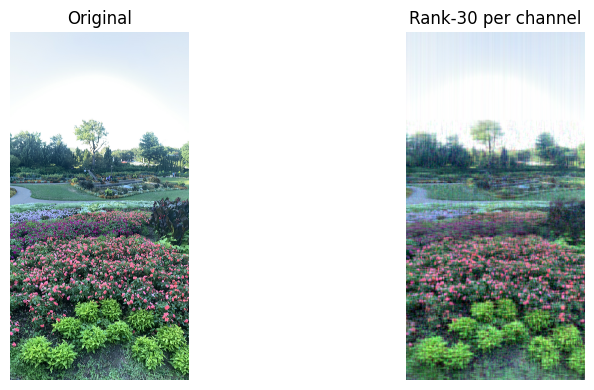

Approx. compression ratio ≈ 84.7×


In [7]:
# Color SVD compression (per-channel)
from PIL import Image

def load_color(path, fallback_shape=(240, 320)):
    try:
        img = Image.open(path).convert('RGB')
        A = np.asarray(img, dtype=float) / 255.0  # (m, n, 3)
        return A, True
    except Exception:
        h, w = fallback_shape
        y, x = np.ogrid[:h, :w]
        R = np.clip(0.5 + 0.5*np.sin(2*np.pi*x/40), 0, 1)
        G = np.clip(0.4 + 0.6*np.sin(2*np.pi*y/50), 0, 1)
        B = np.clip(0.3 + 0.7*np.sin(2*np.pi*(x+y)/60), 0, 1)
        A = np.stack([R, G, B], axis=-1)
        A *= 0.9*np.exp(-(((x-w/2)/200)**2 + ((y-h/2)/150)**2)) + 0.1
        return A, False

def compress_color(A, k):
    m, n, _ = A.shape
    Ak = np.zeros_like(A)
    sigmas = []
    for c in range(3):
        U, s, Vt = np.linalg.svd(A[:,:,c], full_matrices=False)
        sigmas.append(s)
        Uk = U[:, :k]; sk = s[:k]; Vk = Vt[:k, :]
        Ak[:,:,c] = np.clip((Uk * sk) @ Vk, 0, 1)
    return Ak, sigmas

path_color = 'sunken-gardens.jpg'
Acolor, found_c = load_color(path_color)
m, n, _ = Acolor.shape
print(f"Loaded color image: shape={Acolor.shape}, from_file={found_c}")

k = 30
Acolor_k, sigs = compress_color(Acolor, k)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(Acolor); ax[0].set_title('Original'); ax[0].axis('off')
ax[1].imshow(Acolor_k); ax[1].set_title(f'Rank-{k} per channel'); ax[1].axis('off')
plt.tight_layout(); plt.show()

ratio_color = (m*n*3) / (3*k*(m + n + 1))
print(f"Approx. compression ratio ≈ {ratio_color:.1f}×")

### (Optional) PSNR: Peak Signal-to-Noise Ratio (what it measures)
**PSNR** compares a reference image to a distorted/reconstructed image via the mean squared error (MSE). For images scaled to $[0,1]$,
$$
\mathrm{MSE}(A,B) = \frac{1}{mn}\sum_{i,j} (A_{ij} - B_{ij})^2,\quad\quad\mathrm{PSNR}(A,B) = 20\log_{10}(\mathrm{data\_range}) - 10\log_{10}(\mathrm{MSE}).
$$
Higher PSNR (in **dB**) generally means the reconstruction is closer to the original (lower error). It complements relative/Frobenius error with a signal-processing scale.

### 3.4 (Optional) — Plot PSNR vs. rank (grayscale)
Implement PSNR and, for speed, precompute the SVD of the grayscale image once, then reconstruct $A_k$ for many $k$ without recomputing the SVD each time.

In [ ]:
# 3.4 (FAST, Optional) — PSNR vs rank: precompute SVD once and reuse
import numpy as np
import matplotlib.pyplot as plt

def psnr(A, B, data_range=1.0):
    # TODO: implement PSNR from the MSE between A and B
    # mse = np.mean((A - B)**2)
    # if mse == 0: return np.inf
    # return ...
    pass

# Precompute thin SVD once for grayscale image A (from 3.1)
U_A, s_A, Vt_A = np.linalg.svd(A, full_matrices=False)

def reconstruct_from_svd(U, s, Vt, k):
    Uk = U[:, :k]; sk = s[:k]; Vk = Vt[:k, :]
    return (Uk * sk) @ Vk

ks = np.arange(1, min(A.shape), 4)
psnrs = []
for k in ks:
    Ak = reconstruct_from_svd(U_A, s_A, Vt_A, k)
    # Uncomment after implementing psnr:
    # psnrs.append(psnr(A, Ak))
    pass

# plt.figure(figsize=(6,4))
# plt.plot(ks, psnrs, marker='o')
# plt.xlabel('rank k'); plt.ylabel('PSNR (dB)')
# plt.title('PSNR vs rank (grayscale) — single SVD, many k')
# plt.grid(True); plt.show()

## Wrap-up (discussion prompts)
- Geometric roles of $\mathbf{v}_i$ and $\mathbf{u}_i$ in 2D.
- Rank threshold for acceptable image quality (grayscale vs. color).